# 1.4 Friend recommendation in personalized networks

In [1]:
rm(list = ls());
library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [2]:
edge_list <- read.table("facebook_combined.txt");

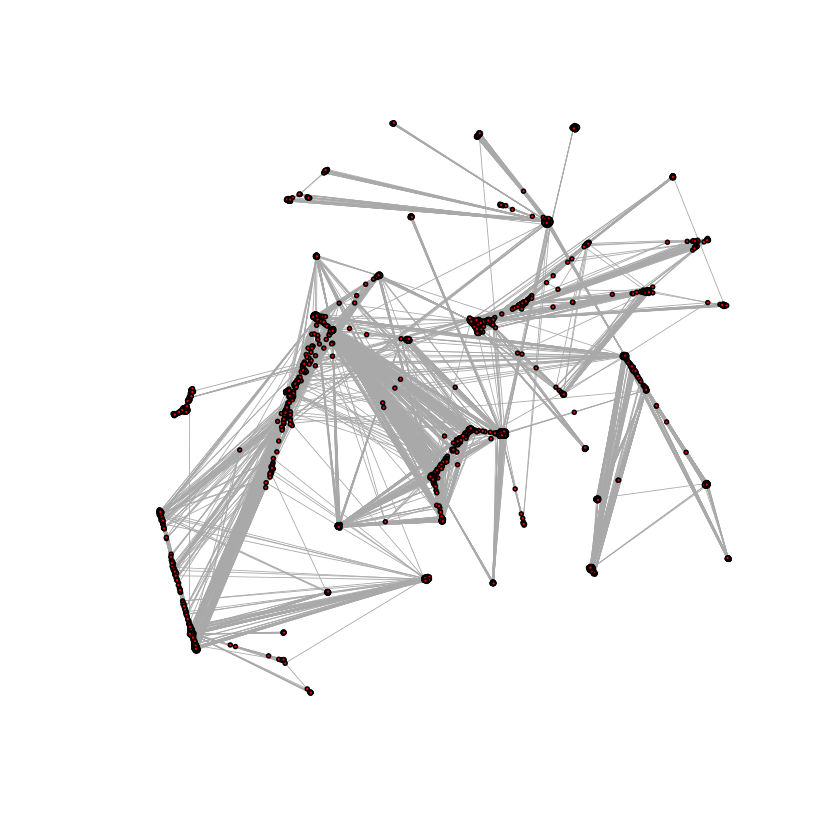

In [3]:
node_list1 <- names(table(edge_list$V1));
node_list2 <- names(table(edge_list$V2));
node_list <- union(node_list1, node_list2);
net <- graph_from_data_frame(d=edge_list, vertices=node_list, directed=FALSE) 
plot(net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

[1] 160

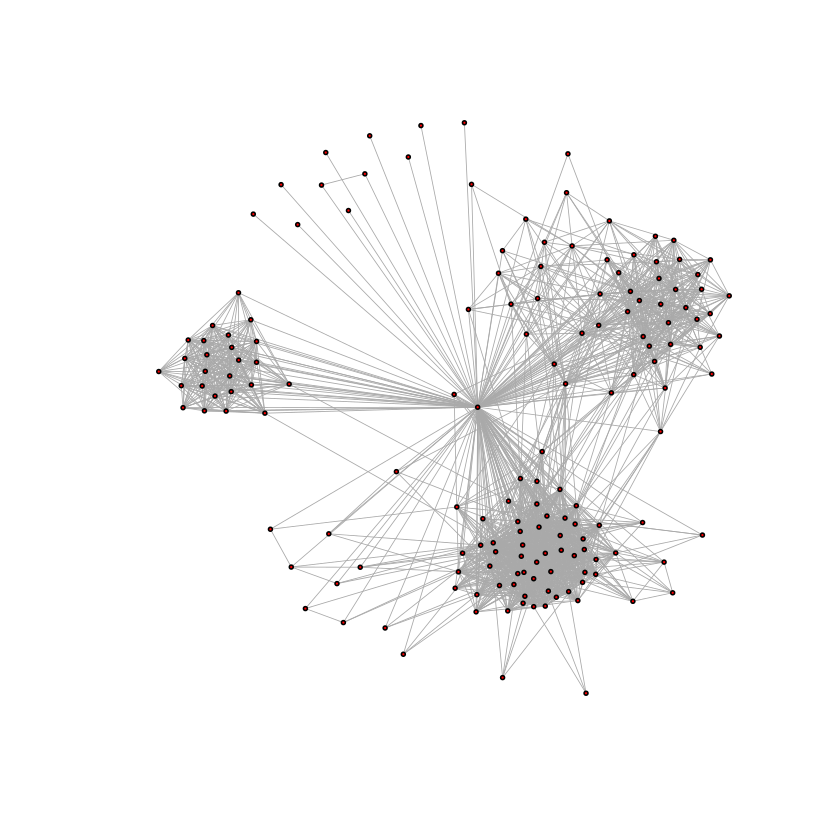

In [4]:
sub_edge_list <- edge_list[(edge_list$V1 == 414) | (edge_list$V2 == 414),];#edges containing node whose ID is 415
#sub_edge_list
sub_node_list <- union(names(table(sub_edge_list$V1)), names(table(sub_edge_list$V2)));

# gengerate induced graph
pernet_415 <- induced_subgraph(net, sub_node_list);
V(pernet_415)$localid<-seq(1:vcount(pernet_415))
vcount(pernet_415)
plot(pernet_415,vertex.size=1,vertex.label=NA, vertex.color="red",edge.width=0.5,edge.arrow.size=0.1);

## Question 16

In [5]:
degreeseq <- degree(pernet_415)
Nr <- as.integer(names(degreeseq[which(degreeseq==24)]))
print(paste("Number of users in Nr =",length(Nr),sep=" "));

[1] "Number of users in Nr = 11"


In [6]:
Nr_list<-rep(0,length(Nr))
i<-1
for(v in V(pernet_415))
{
    if(degree(pernet_415,v)==24)
    {
        Nr_list[i]=v
        i<-i+1
    }
}

### Average accuracy of friends recommendation algorithm

In [7]:
CommonNeighbor<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersect <- intersection(ineighbors,jneighbors)
    return(length(intersect))
}

In [8]:
Jaccard<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersec <- intersection(ineighbors,jneighbors)
    uni <-union(ineighbors,jneighbors)
    return(length(intersec)/length(uni))
}

In [9]:
Adamic_Adar<-function(network,i,j)
{
    ineighbors <- neighbors(network,i,mode = "total")
    jneighbors <- neighbors(network,j,mode = "total")
    intersect <- intersection(ineighbors,jneighbors)
    metric=0
    for(n in intersect)
    {
        nn<- neighbors(network,n,mode = "total")
        metric<- metric+1/(log(length(nn)))
    }
    return(metric)
}

In [10]:
Recommend_K_Users<-function(network,user,K,metric)
{
    user_neighbors<-neighbors(network,user,mode = "total")
    non_neighbors<-difference(V(network),user_neighbors)
    nnon<-length(non_neighbors)
    metric_value<-rep(0,nnon)
    
    if(metric=="CommonNeighbor")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-CommonNeighbor(network,user,non_neighbors[i])
        }
    }
    
    else if(metric=="Jaccard")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-Jaccard(network,user,non_neighbors[i])
        }
    }
    
    else if(metric=="Adamic_Adar")
    {
        for(i in seq(1:nnon))
        {
            metric_value[i]<-Adamic_Adar(network,user,non_neighbors[i])
        }
    }
    
    df<-data.frame(non_neighbors$localid,metric_value)
    rownames(df) <- df$non_neighbors
    df_sorted <- df[order(-metric_value),]
    end<-K+1
    return(df_sorted[2:end,]$non_neighbors.localid)
}

In [11]:
Accuracy_one_user<-function(network,user,metric)
{
    score<-rep(0,10)
    neighbors<-neighbors(network,user,mode = "total")
    removed_n<-floor(length(neighbors)*0.25)
    for(i in seq(1,10)){
        removed_node<-sample(neighbors,size=removed_n,replace=FALSE)
        network_edge_removed<-network
        for(j in seq(1,removed_n))
        {#note to use different loop variable other than i !
            neighborid<-removed_node[j]$localid
            edgeid<-get.edge.ids(network_edge_removed, c(user,neighborid))#convert id!!need local id !
            network_edge_removed<-delete_edges(network_edge_removed,edgeid)
        }
        recommended_node<-Recommend_K_Users(network_edge_removed,user,removed_n,metric)
        score[i]<-length(intersection(removed_node,recommended_node))/removed_n
    }
    return(mean(score))
}

In [16]:
len<-length(Nr_list)
cn_score<-rep(0,len)
jaccard_score<-rep(0,len)
adamicadar_score<-rep(0,len)
for(i in seq(1,len))
{
    cn_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"CommonNeighbor")
    jaccard_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Jaccard")
    adamicadar_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Adamic_Adar")
}

In [17]:
print(paste("Common Neighbors Measure:",mean(cn_score)))

[1] "Common Neighbors Measure: 0.731818181818182"


In [18]:
print(paste("Jaccard Measure:",mean(jaccard_score)))

[1] "Jaccard Measure: 0.810606060606061"


In [19]:
print(paste("Adamic_Adar Measure:",mean(adamicadar_score)))

[1] "Adamic_Adar Measure: 0.712121212121212"


In [22]:
len<-length(Nr_list)
cn_score<-rep(0,len)
jaccard_score<-rep(0,len)
adamicadar_score<-rep(0,len)
for(i in seq(1,len))
{
    cn_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"CommonNeighbor")
    jaccard_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Jaccard")
    adamicadar_score[i]<-Accuracy_one_user(pernet_415,Nr_list[i],"Adamic_Adar")
}
print(paste("Common Neighbors Measure:",mean(cn_score)))
print(paste("Jaccard Measure:",mean(jaccard_score)))
print(paste("Adamic_Adar Measure:",mean(adamicadar_score)))

[1] "Common Neighbors Measure: 0.728787878787879"
[1] "Jaccard Measure: 0.807575757575758"
[1] "Adamic_Adar Measure: 0.725757575757576"
